<a href="https://colab.research.google.com/github/inbalh1/ML/blob/main/DL_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda device
Files already downloaded and verified
Files already downloaded and verified
0.001
0.5
2.5
linear_relu_stack.0.weight Parameter containing:
tensor([[-0.4040,  4.1538,  3.9677,  ...,  2.1561,  5.7466, -1.8322],
        [-0.8679, -2.0312,  3.2370,  ..., -1.1132, -0.3474, -0.0911],
        [ 1.8236, -4.3124, -3.6771,  ..., -1.6617,  1.6285,  2.1214],
        ...,
        [ 0.8944, -0.1653, -2.3597,  ...,  0.3337,  2.6698, -1.2430],
        [-0.1854,  3.5965,  2.6563,  ...,  0.3198, -1.6843,  1.6330],
        [-1.6915,  3.5048, -1.9217,  ..., -0.7926, -1.9742,  2.1874]],
       device='cuda:0', requires_grad=True)
linear_relu_stack.0.bias Parameter containing:
tensor([-3.7531e+00,  2.8275e+00, -4.6132e+00,  4.5471e-01,  1.8423e-01,
        -1.2174e+00, -4.0026e-01,  1.5917e+00, -4.0583e+00,  1.4927e+00,
        -4.6483e-03,  3.1037e+00, -2.9726e+00, -1.5423e+00, -1.7654e+00,
         6.2449e-01,  2.4461e+00, -3.4186e+00, -5.7997e-01,  2.6657e+00,
        -2.6111e+00,  2.09

NameError: ignored

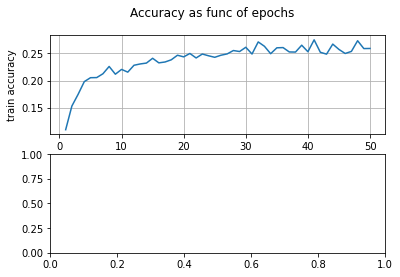

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.svm import SVC

#TODO: make the inputs 3 channels instead of 3072 individual values
#TODO: complete grid search over hyperparameters

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

BATCH_SIZE = 64
TRAIN_SIZE = 5000
TEST_SIZE = 1000


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,# set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

def svm_by_type(kernel , X , y , X_test , y_test):
  clf_SVC = SVC(kernel=kernel , decision_function_shape='ovr')
  clf_SVC.fit(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y)
  print("train acc: ", clf_SVC.score(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y))
  print("test acc: ", clf_SVC.score(X_test.reshape([TEST_SIZE, 3 * 32 * 32]), y_test))
  print("number of classes: ", clf_SVC.classes_)
  
  
# TODO: should choose parameters here
config = {
    "step_size": [1e-3 , 1e-2 , 2e-2 , 3e-2 , 0.1],
    "momentum": [ 0.45 , 0.5 , 0.55 , 0.7 , 0.8 , 0.9],
    "deviation": [ 1 , 1.5 , 2 , 2.25 , 2.5 ,  3]
}


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

      

def init_weights_wrapper(deviation):
  def init_weights(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight , std=deviation)
      torch.nn.init.normal_(m.bias , std=deviation)
  return init_weights


class GridSearch():
  def __init__(self):
    self.best_params = {}
    self.best_acc = 0

  def update_params(self, step_size, momentum, deviation):
    self.best_params['step_size'] = step_size
    self.best_params['momentum'] = momentum
    self.best_params['deviation'] = deviation

  def run(self, train_dataloader, config):
    for step_size in config["step_size"]:
      for momentum in config["momentum"]:
        for deviation in config["deviation"]:
          model = NeuralNetwork().to(device)
          model.apply(init_weights_wrapper(deviation))

          loss_fn = nn.CrossEntropyLoss()
          optimizer = torch.optim.SGD(model.parameters(), lr=step_size , momentum=momentum)
          all_accuracy, _ = train(train_dataloader, model, loss_fn, optimizer )
          accuracy = all_accuracy[-1] # Take last accuracy
          if accuracy > self.best_acc:
            self.update_params(step_size, momentum, deviation)
            self.best_acc = accuracy

  
# Returns the accuracy
def train(dataloader, model, loss_fn, optimizer , num_of_batches = -1, num_of_epochs=50):
    size = TRAIN_SIZE #TODO: change size to match num_of_batches
    model.train()
    epoch_loss, epoch_accuracy = 0, 0
    all_loss, all_accuracy = [], [] # loss and accuracy per epoch
    for i in range(num_of_epochs):
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss = loss.item()
          if batch % 100 == 0:
              current = (batch + 1) * len(X)
              print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
          epoch_loss += loss
          epoch_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
          if num_of_batches == 0 :
            break
          else:
            num_of_batches -=1
      all_accuracy.append(epoch_accuracy / size)
      if (num_of_batches > -1):
        all_loss.append(epoch_loss / num_of_batches)
      else:
        all_loss.append(epoch_loss / len(dataloader))
      
      epoch_accuracy = 0
      epoch_loss = 0
    #all_loss /= num_batches
    return all_accuracy, all_loss


def test(dataloader, model, loss_fn , num_of_batches = -1):
    size = TEST_SIZE #len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if num_of_batches == 0 :
              break
            else:
              num_of_batches -=1
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


if __name__ == "__main__":
  train_sampler = torch.utils.data.RandomSampler(training_data, replacement=True, num_samples=TRAIN_SIZE, generator=None)
  test_sampler = torch.utils.data.RandomSampler(test_data, replacement=True, num_samples=TEST_SIZE, generator=None)



  # Loaders for SVM (load everything)
  train_dataloader = DataLoader(training_data, batch_size=TRAIN_SIZE , sampler = train_sampler)
  test_dataloader = DataLoader(test_data, batch_size=TEST_SIZE, sampler = test_sampler)

  X , y = next(iter(train_dataloader))
  X_test , y_test = next(iter(test_dataloader))

  # linear SVM:
  #svm_by_type('linear' , X , y , X_test , y_test)

  

  # rbf kernel SVM
  #svm_by_type('rbf' , X , y , X_test , y_test)

  # Loaders for NN
  train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE , sampler = train_sampler)
  test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, sampler = test_sampler)

  # Choose best parameters
  """
  gs = GridSearch()
  gs.run(train_dataloader, config)
  best_step_size = gs.best_params["step_size"]
  best_momentum = gs.best_params["momentum"]
  best_deviation =  gs.best_params["deviation"]
  """

  best_step_size = 0.001
  best_momentum = 0.5
  best_deviation = 2.5

  print(best_step_size)
  print(best_momentum)
  print(best_deviation)


  # Train the network with the best parameters and then test it
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(best_deviation))
  for name, param in model.named_parameters():
          print(name , param)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=best_step_size , momentum=best_momentum)
  all_accuracy, all_loss = train(train_dataloader, model, loss_fn, optimizer)
  epochs = [(x + 1) for x in range(len(all_accuracy))]
  fig, axs = plt.subplots(2)
  fig.suptitle("Accuracy as func of epochs")
  # Plot
  axs[0].plot(epochs, all_accuracy)

  axs[0].set(xlabel='epochs', ylabel='train accuracy')
  axs[0].grid()

  test(test_dataloader, model, loss_fn)

  axs[1].plot(epochs, test_accuracy)

  axs[1].set(xlabel='epochs', ylabel='test accuracy')
  axs[1].grid()

  save = False
  if save:
      plt.savefig("title for plt")
      
  # Draw losses as well
  plt.show()
  print("end")

In [ ]:
# This isn't relevant (didn't work)
# TODO: delete
from sklearn.model_selection import GridSearchCV
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

BATCH_SIZE = 64
TRAIN_SIZE = 5000
TEST_SIZE = 1000


config = {
    "step_size": [1e-3],
    "momentum": [0.9],
    "deviation": [1]
}


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,# set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

      

def init_weights_wrapper(deviation):
  def init_weights(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight , std=deviation)
      torch.nn.init.normal_(m.bias , std=deviation)
  return init_weights

def search_params(step_size, momentum, deviation):
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(deviation))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=step_size , momentum=momentum)
  train(train_dataloader, model, loss_fn, optimizer)



class ParameterSearch():
  def  __init__(self):
    pass
  def fit(self):
    pass
  def score(self):
    return 0


gs = GridSearchCV(ParameterSearch(),  param_grid=config #,
        #refit=False, scoring='accuracy', verbose=1, cv=2
    )
train_sampler = torch.utils.data.RandomSampler(training_data, replacement=True, num_samples=TRAIN_SIZE, generator=None)
test_sampler = torch.utils.data.RandomSampler(test_data, replacement=True, num_samples=TEST_SIZE, generator=None)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE , sampler = train_sampler)
for i, data in enumerate(train_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    outputs = gs.fit(image, labels)



Using cuda device
Files already downloaded and verified
Files already downloaded and verified


TypeError: ignored